In [49]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import time
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.integrate import odeint

sys.path.append('/Users/rdgao/Documents/code/research/SpaceRecon/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')

from fooof import FOOOF
from fooof import FOOOFGroup
import neurodsp as ndsp
from nlds import delayembed as de
from nlds import dfa, utils, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def lorenz(X, t, sigma, beta, rho):
    """The Lorenz equations."""
    u, v, w = X
    up = -sigma*(u - v)
    vp = rho*u - v - u*w
    wp = -beta*w + u*v
    return up, vp, wp

def sim_lorenz(T, fs, init, args):
    t = np.arange(0,T,1/fs)
    f = odeint(lorenz, init, t, args)
    x, y, z = f.T
    return x,y,z

In [3]:
def compute_delayembedding(data, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr):
    MI, opt_delay, recon_dim, pfnn = [],[],[],[]
    for i in range(np.shape(data)[0]):
        MI.append(de.compute_delay_MI(data[i,:], nbins, max_tau)[1])
        opt_delay.append(de.find_valley(MI[i]))
        rd, p = de.pfnn_de_dim(data[i,:],opt_delay[i][0], max_dim, pfnn_thr, R_thr, A_thr)
        recon_dim.append(rd)
        pfnn.append(p)
        print(opt_delay[i], rd)
    return np.array(MI), np.array(opt_delay), np.array(recon_dim), np.array(pfnn)

def plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=False):
    plt.subplot(1,3,1)
    plt.plot(MI.T)
    plt.plot(opt_delay[:,0],opt_delay[:,1], 'ok')
    plt.xlabel('Tau')
    plt.ylabel('MI')
    plt.title('Lagged Mutual Information')

    plt.subplot(1,3,2)
    if log_pfnn:
        plt.semilogy(range(1,max_dim+1), pfnn.T, 'o-', alpha=0.8, lw=1)
    else:
        plt.plot(range(1,max_dim+1), pfnn.T, 'o-', alpha=0.8, lw=1)
    plt.plot(range(1,max_dim+1), pfnn.mean(axis=0), 'ko-', lw=2)
    plt.plot(range(1,max_dim+1), pfnn_thr*np.ones(max_dim), 'k--')
    
    plt.xlabel('Dimension')
    plt.ylabel('PFNN');
    plt.title('Proportion of False Nearest Neighbors')
    
    if len(np.shape(data_de))==3:
        # 3D reconstruction
        ax = plt.subplot(1,3,3, projection='3d')
        tau = opt_delay[plot_chan][0]
        ax.plot3D(data_de[0,::plot_step],data_de[1,::plot_step],data_de[2,::plot_step], 'k', alpha=0.5, lw=1)
        ax.set_xlabel('d1'); ax.set_ylabel('d2'); ax.set_zlabel('d3')
    else:
        plt.subplot(1,3,3)
        tau = opt_delay[plot_chan][0]
        plt.plot(data_de[0,::plot_step],data_de[1,::plot_step], 'k', alpha=0.5, lw=1)
        plt.xlabel('d1'); plt.ylabel('d2');

    plt.tight_layout()

# Can Delay Embedding Retrieve Projected Trajectory?
The first test is to see whether a 3D phase space trajectory projected onto 1D can be correctly retrieved by delay embedding. I'll test 3 different projections: 
1. Just pick one state variable.
2. Sum the variables.
3. Gaussian random matrix.

We'll use the trusty Lorenze attractor with chaotic parameters.

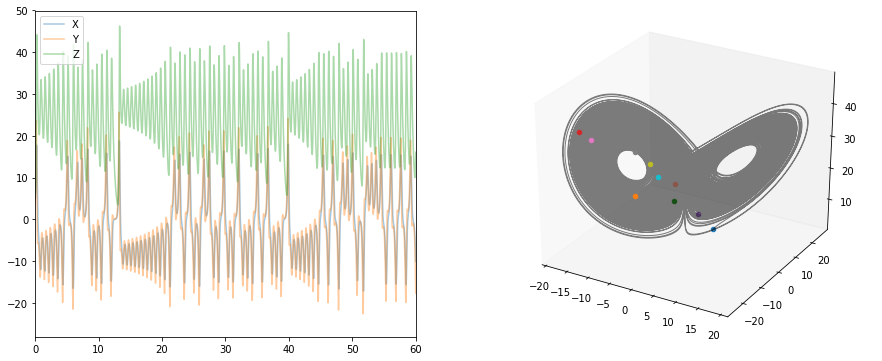

In [51]:
# Lorenz paramters and initial conditions
T,fs = 300,500
t = np.arange(0,T,1/fs)
sigma, beta, rho = 10, 2.667, 28
#u0, v0, w0 = 1, 1, 1.05
u0, v0, w0 = np.random.randint(0,10,size=3)
x,y,z = sim_lorenz(T,fs,init=(u0, v0, w0), args=(sigma, beta, rho))

# plot 
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(t, x, t,y, t,z, alpha=0.4)
plt.legend(['X', 'Y', 'Z'])
plt.xlim([0,60])
ax = plt.subplot(1,2,2, projection='3d')
plotting.plot_statespace_trial(ax, np.array([x,y,z]).T, mark_ind=range(0,10000,1000), alpha=0.5)

# Test 1 & 2: use 1 of the state variables, and the sum, for delay embedding

In [6]:
data = np.array([x,y,z, x+y+z])
nbins, max_tau = 50,1000, 
max_dim, pfnn_thr, R_thr, A_thr = 6, 0.01, 15., 2.
MI, opt_delay, recon_dim, pfnn = compute_delayembedding(data, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr)

(81, 0.9039201096105265) 3
(76, 0.9052752240339544) 3
(74, 0.7528764608545706) 3
(77, 0.7421519470654128) 3


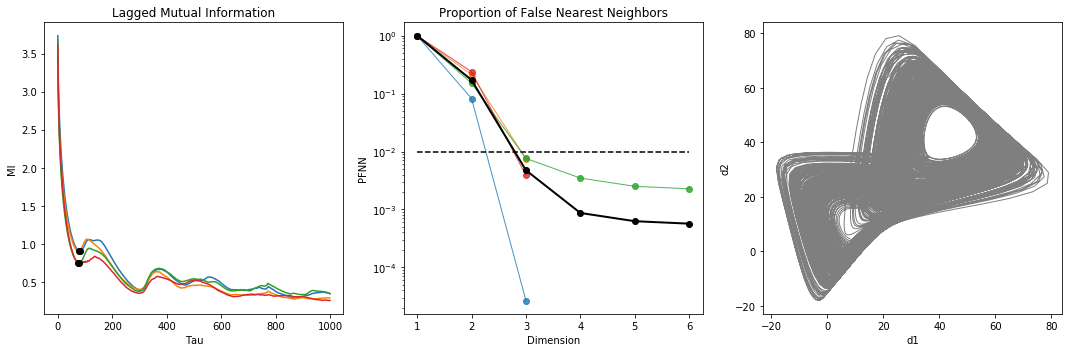

In [7]:
plot_chan, plot_step = 3, 10
data_de = de.delay_embed(data[plot_chan,:], int(opt_delay[plot_chan,0]), recon_dim[plot_chan]).T
plt.figure(figsize=(15,5))
plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=True)

### Works as expected
Delay embedding gets the dimensionality of the phase space correct (3), for both single state variable and sum embedding, even though the chaotic attractor itself really has a fractional dimension. Beyond that though, I realized I have no good idea on how to measure the phase space similarity between the original and reconstructed signal. 

# Test 3: random projection, 50 trials

(0, 300)

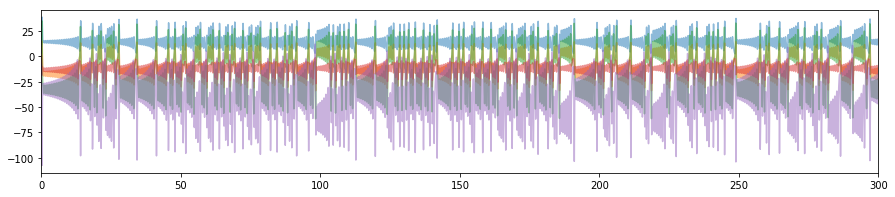

In [62]:
np.random.seed(42)
ntrials = 50
data = np.array([x,y,z])
rand = np.random.randn(ntrials,data.shape[0])
data = np.matmul(rand, data)
plt.figure(figsize=(15,3))
plt.plot(t, data[:5,:].T, alpha=0.5)
plt.xlim([0,T])

In [63]:
nbins, max_tau = 50,1000, 
max_dim, pfnn_thr, R_thr, A_thr = 6, 0.01, 15., 2.
MI, opt_delay, recon_dim, pfnn = compute_delayembedding(data, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr)

(83, 0.5546623215874403) 4
(81, 0.8420368625422576) 3
(79, 0.8450796935361522) 3
(84, 0.5221744654872482) 4
(78, 0.6193220658002154) 4
(77, 0.8653205922882727) 3
(77, 0.6661086281794497) 3
(83, 0.5735134387135212) 5
(81, 0.548626608800496) 4
(69, 0.5416360714383359) 4
(72, 0.7156616183847448) 3
(76, 0.610725072466797) 6
(74, 0.6355880689809469) 4
(77, 0.8374235251569044) 3
(84, 0.57597927943008) 4
(81, 0.6064993482436414) 3
(74, 0.773486399639285) 3
(76, 0.6883870550893005) 3
(78, 0.741764458647818) 3
(82, 0.6045142429163607) 4
(83, 0.5511275158031765) 4
(79, 0.537840162837015) 4
(78, 0.7055419004329389) 3
(83, 0.5315504361363448) 5
(78, 0.6116775967480992) 4
(80, 0.7694189219961779) 3
(76, 0.8023187984422113) 3
(74, 0.81815204178749) 3
(81, 0.6382862470919357) 3
(74, 0.613049556705191) 4
(75, 0.6752866256639034) 3
(81, 0.5638992082924222) 4
(78, 0.8798542609519494) 3
(78, 0.7954741376276128) 3
(78, 0.8582708838226694) 3
(77, 0.8745077714310636) 3
(83, 0.622794708815623) 6
(76, 0.65589

3.7


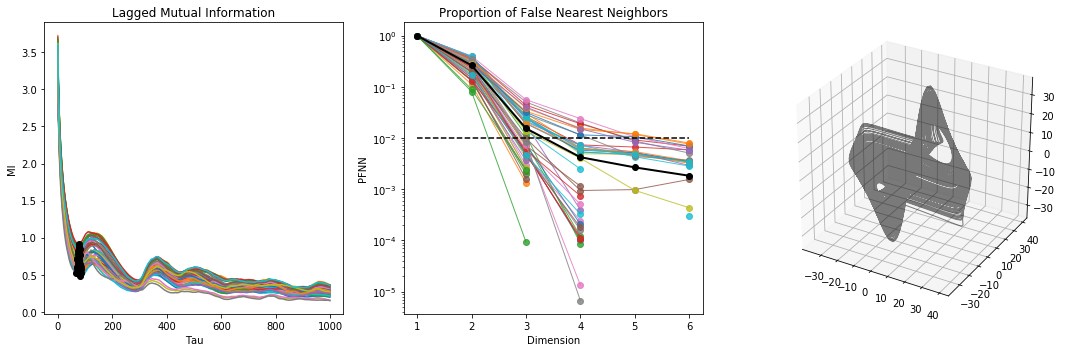

In [74]:
plot_chan, plot_step = 10, 10
data_de = de.delay_embed(data[plot_chan,:], int(opt_delay[plot_chan,0]), recon_dim[plot_chan]).T
plt.figure(figsize=(15,5))
plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=True)
print(recon_dim.mean())

### Doesn't do too hot on random projections
Over-estimates dimension on random projection data, most of the time only by 1 and only just above the pfnn threshold, but sometimes by a lot, though in most cases pfnn by dim=3 is below 0.1. Reconstructed attractor looks...fine? Again, no real way of evaluating this.

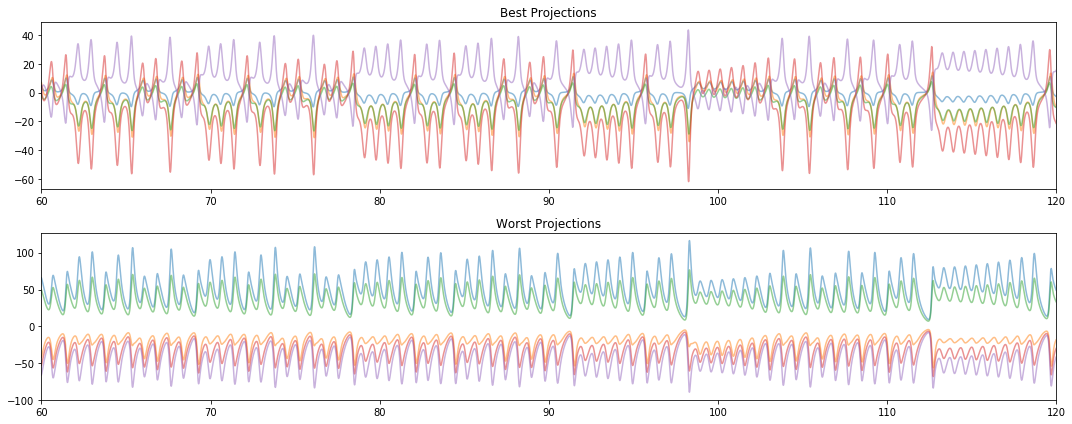

In [104]:
inds_by_err = np.argsort(pfnn[:,2])
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t, data[inds_by_err[:5],:].T, alpha=0.5)
plt.title('Best Projections')
plt.xlim([60,120])
plt.subplot(2,1,2)
plt.plot(t, data[inds_by_err[-5:],:].T, alpha=0.5)
plt.title('Worst Projections')
plt.xlim([60,120])
plt.tight_layout()

Nothing immediately obvious as to what's wrong with the worst projections, other than that the mean value and variance seem to be bigger?

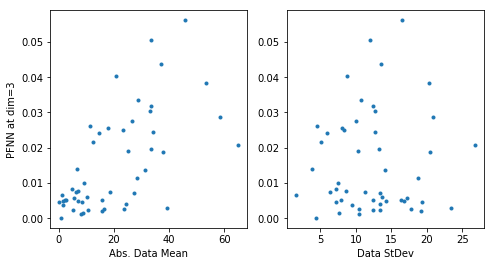

In [186]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(np.abs(data.mean(axis=1)), pfnn[:,2], '.')
plt.xlabel('Abs. Data Mean')
plt.ylabel('PFNN at dim=3')
plt.subplot(1,3,2)
plt.plot(data.std(axis=1), pfnn[:,2], '.')
plt.xlabel('Data StDev');

### Reconstruction quality seems to depend on data being mean-centered?

In [129]:
# z-score data
data_z = ((data - data.mean(axis=1)[:, np.newaxis])/(data.std(axis=1)[:, np.newaxis]))
MI, opt_delay, recon_dim, pfnn = compute_delayembedding(data_z, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr)

(83, 0.5546623215874403) 4
(81, 0.8420368625422576) 3
(79, 0.8450796935361522) 3
(84, 0.5221744654872482) 4
(78, 0.6193220658002154) 4
(77, 0.8653205922882727) 3
(77, 0.6661086281794497) 3
(83, 0.5735134387135212) 5
(81, 0.548626608800496) 4
(69, 0.5416360714383359) 4
(72, 0.7156616183847448) 3
(76, 0.610725072466797) 6
(74, 0.6355880689809469) 4
(77, 0.8374235251569044) 3
(84, 0.57597927943008) 4
(81, 0.6064993482436414) 3
(74, 0.773486399639285) 3
(76, 0.6883870550893005) 3
(78, 0.741764458647818) 3
(82, 0.6045142429163607) 4
(83, 0.5511275158031765) 4
(79, 0.537840162837015) 4
(78, 0.7055419004329389) 3
(83, 0.5315504361363448) 5
(78, 0.6116775967480992) 4
(80, 0.7694189219961779) 3
(76, 0.8023187984422113) 3
(74, 0.81815204178749) 3
(81, 0.6382862470919357) 3
(74, 0.613049556705191) 4
(75, 0.6752866256639034) 3
(81, 0.5638992082924222) 4
(78, 0.8798542609519494) 3
(78, 0.7954741376276128) 3
(78, 0.8582708838226694) 3
(77, 0.8745077714310636) 3
(83, 0.622794708815623) 6
(76, 0.65589

3.7


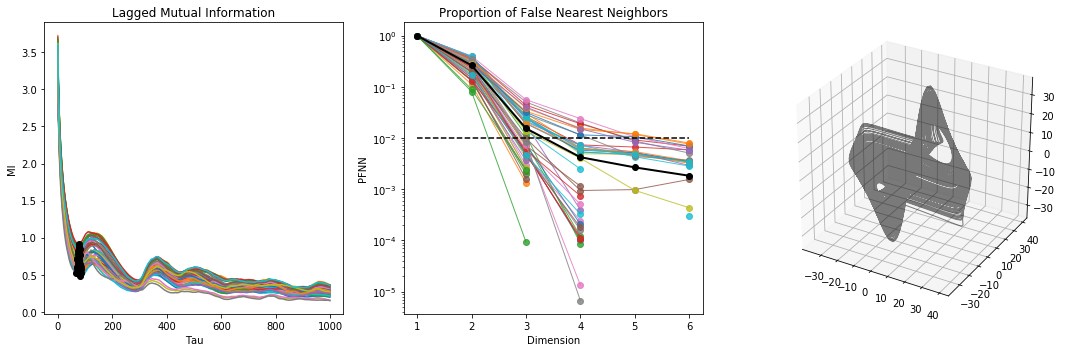

In [130]:
plot_chan, plot_step = 10, 10
data_de = de.delay_embed(data_z[plot_chan,:], int(opt_delay[plot_chan,0]), recon_dim[plot_chan]).T
plt.figure(figsize=(15,5))
plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=True)
print(recon_dim.mean())

### Literally no changes to reconstruction quality after demeaning.

ValueError: x and y must have same first dimension, but have shapes (50,) and (20,)

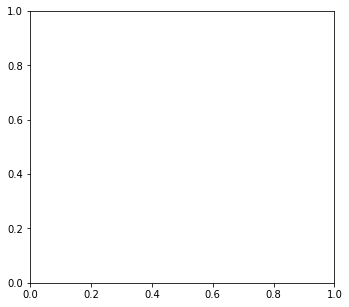

In [291]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.abs(data_z.mean(axis=1)), pfnn[:,2], '.')
plt.xlabel('Abs. Data Mean')
plt.ylabel('PFNN at dim=3')
ax = plt.subplot(1,2,2, projection='3d')
ax.scatter3D(rand[:,0],rand[:,1],rand[:,2], c=pfnn[:,2], depthshade=True, s=80)
for i in range(ntrials):
    ax.plot([0,rand[i,0]],[0,rand[i,1]],[0,rand[i,2]], 'k-', alpha=0.2)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(rand[:,0],rand[:,1], c=pfnn[:,2], s=40)
plt.xlabel('X');plt.ylabel('Y')
plt.subplot(1,3,2)
plt.scatter(rand[:,0],rand[:,2], c=pfnn[:,2], s=40)
plt.xlabel('X');plt.ylabel('Z')
plt.subplot(1,3,3)
plt.scatter(rand[:,1],rand[:,2], c=pfnn[:,2], s=40)
plt.xlabel('Y');plt.ylabel('Z')
plt.colorbar()
plt.tight_layout()

### Pathological projection
Reconstruction error doesn't seem to be related to being mean-centered, though even left-over mean from machine precision is still correlated with error. 

From the random projection vectors, it seems like that when X and Y are negatively correlated, pfnn at dim 3 increases. Looking at the time series, X and Y are extremely correlated, just slightly out of phase and with a small scaling constant. So if the projection occurs such that X and Y cancel each other out, information may be irretrievably lost. However, this looks to be a specific feature of the Lorenz attractor, at least along those particular dimensions. If the high-dimensional phase space has correlated dimensions that were orthogonally projected onto, i.e. looking at a wire/line from the end, reconstruction will not be good. This should not be a problem with non-negative random matrices.

(0, 60)

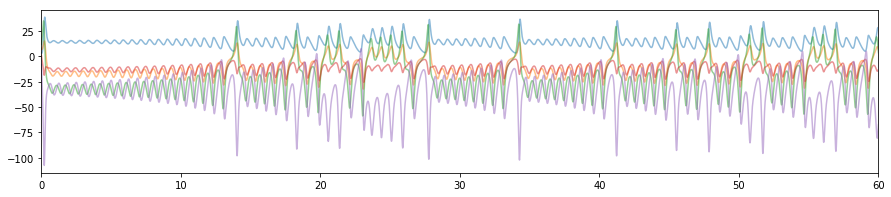

In [197]:
data = np.array([x,y,z])
rand_nonN = rand-rand.min()*5 # make the projection matrix non-negative by shifting
data_nonN = np.matmul(rand, data)
plt.figure(figsize=(15,3))
plt.plot(t, data_nonN[:5,:].T, alpha=0.5)
plt.xlim([0,60])

In [198]:
MI, opt_delay, recon_dim, pfnn = compute_delayembedding(data_nonN, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr)

(83, 0.5546623215874403) 4
(81, 0.8420368625422576) 3
(79, 0.8450796935361522) 3
(84, 0.5221744654872482) 4
(78, 0.6193220658002154) 4
(77, 0.8653205922882727) 3
(77, 0.6661086281794497) 3
(83, 0.5735134387135212) 5
(81, 0.548626608800496) 4
(69, 0.5416360714383359) 4
(72, 0.7156616183847448) 3
(76, 0.610725072466797) 6
(74, 0.6355880689809469) 4
(77, 0.8374235251569044) 3
(84, 0.57597927943008) 4
(81, 0.6064993482436414) 3
(74, 0.773486399639285) 3
(76, 0.6883870550893005) 3
(78, 0.741764458647818) 3
(82, 0.6045142429163607) 4
(83, 0.5511275158031765) 4
(79, 0.537840162837015) 4
(78, 0.7055419004329389) 3
(83, 0.5315504361363448) 5
(78, 0.6116775967480992) 4
(80, 0.7694189219961779) 3
(76, 0.8023187984422113) 3
(74, 0.81815204178749) 3
(81, 0.6382862470919357) 3
(74, 0.613049556705191) 4
(75, 0.6752866256639034) 3
(81, 0.5638992082924222) 4
(78, 0.8798542609519494) 3
(78, 0.7954741376276128) 3
(78, 0.8582708838226694) 3
(77, 0.8745077714310636) 3
(83, 0.622794708815623) 6
(76, 0.65589

3.7


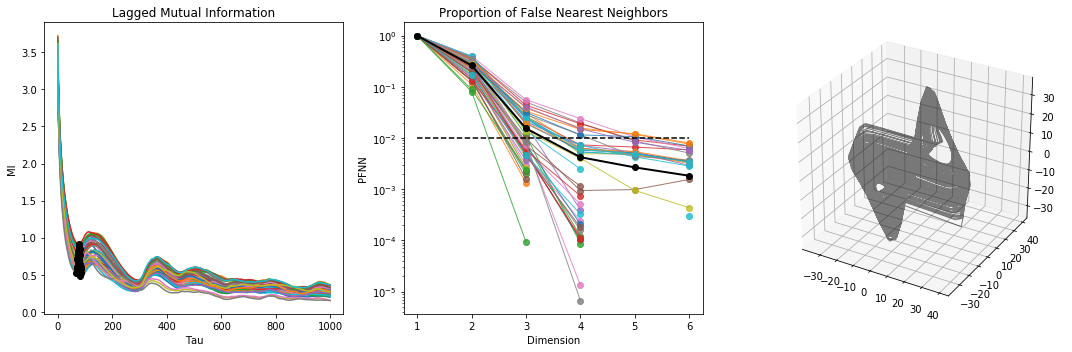

In [206]:
plot_chan, plot_step = 10, 20
data_de = de.delay_embed(data_nonN[plot_chan,:], int(opt_delay[plot_chan,0]), recon_dim[plot_chan]).T
plt.figure(figsize=(15,5))
plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=True)
print(recon_dim.mean())

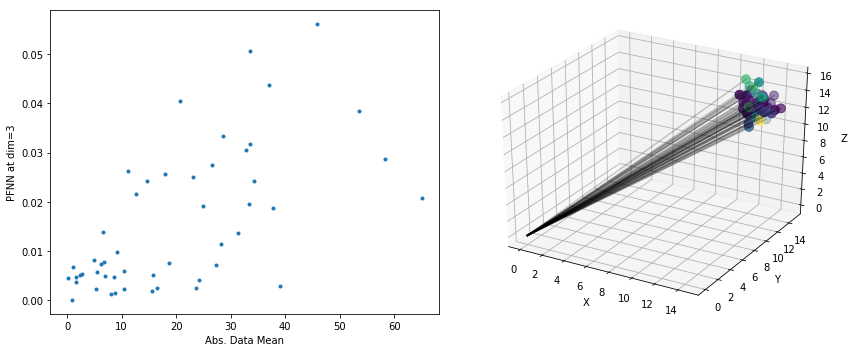

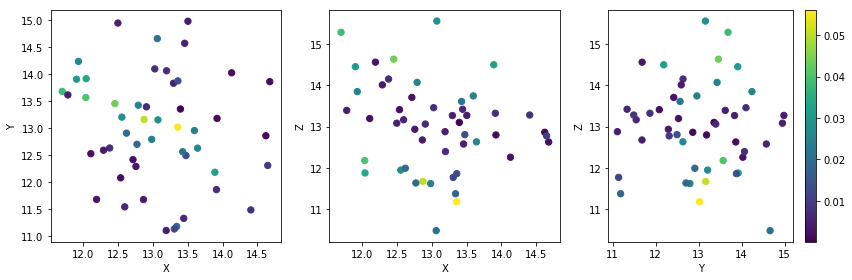

In [207]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.abs(data_nonN.mean(axis=1)), pfnn[:,2], '.')
plt.xlabel('Abs. Data Mean')
plt.ylabel('PFNN at dim=3')
ax = plt.subplot(1,2,2, projection='3d')
ax.scatter3D(rand_nonN[:,0],rand_nonN[:,1],rand_nonN[:,2], c=pfnn[:,2], depthshade=True, s=80)
for i in range(ntrials):
    ax.plot([0,rand_nonN[i,0]],[0,rand_nonN[i,1]],[0,rand_nonN[i,2]], 'k-', alpha=0.2)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(rand_nonN[:,0],rand_nonN[:,1], c=pfnn[:,2], s=40)
plt.xlabel('X');plt.ylabel('Y')
plt.subplot(1,3,2)
plt.scatter(rand_nonN[:,0],rand_nonN[:,2], c=pfnn[:,2], s=40)
plt.xlabel('X');plt.ylabel('Z')
plt.subplot(1,3,3)
plt.scatter(rand_nonN[:,1],rand_nonN[:,2], c=pfnn[:,2], s=40)
plt.xlabel('Y');plt.ylabel('Z')
plt.colorbar()
plt.tight_layout()

Okay well there goes that hypothesis. I think the mere negative correlation is enough to be considered a pathological projection. But enough screwing around here.

# Conclusion
Delay embedding reconstruction of randomly projected data seems to be satisfactory, unless there is a pathological projection. Although, I still need to find a good method of measuring the trajectory/manifold similarities. Maybe starting with a chaotic attractor is not the best idea.

# Van der Pol oscillator
Test delay embedding with a less complex attractor basin, the van der Pol oscillator.

In [244]:
def vanderpol(X, t, mu):
    x,y = X
    dxdt = mu * (x - (1./3.)*x**3. - y)
    dydt = x / mu
    return dxdt, dydt

def sim_vanderpol(T, fs, init, mu):
    t = np.arange(0,T,1/fs)
    f = odeint(vanderpol, init, t, mu)
    x, y = f.T
    return x,y

Text(0.5,0.92,'Up-projected Data (3D)')

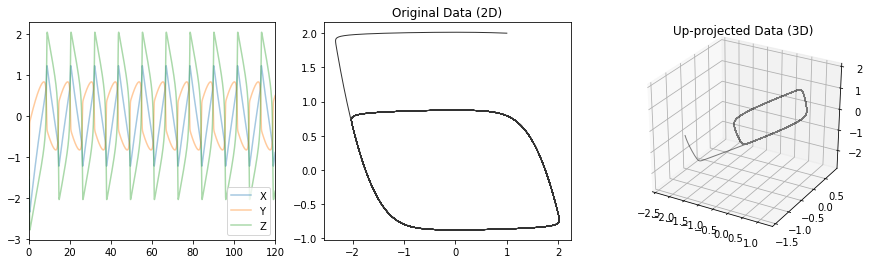

In [293]:
# vdP paramters and initial conditions
np.random.seed(43)
T,fs = 300,200
t = np.arange(0,T,1/fs)
mu = 5.
X0 = (1.,2.,)
x_o,y_o = sim_vanderpol(T,fs,X0,(mu,))
# project into 3D
data = np.matmul(np.random.randn(3,2), np.array([x_o,y_o]))
x,y,z = data

# plot 
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(t, x, t,y,t,z, alpha=0.4)
plt.legend(['X', 'Y', 'Z'])
plt.xlim([0,120])

plt.subplot(1,3,2)
plt.plot(x_o, y_o, '-k', alpha=0.8, lw=1)
plt.title('Original Data (2D)')

ax = plt.subplot(1,3,3, projection='3d')
ax.plot3D(x,y,z, 'k', alpha=0.5, lw=1)
plt.title('Up-projected Data (3D)')

In [283]:
data = np.array([x,y,z,x+y+z])
nbins, max_tau = 50,300
max_dim, pfnn_thr, R_thr, A_thr = 5, 0.01, 15., 2.
MI, opt_delay, recon_dim, pfnn = compute_delayembedding(data, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr)

(24, 2.476107770569637) 2
(3, 2.6959574900234573) 2
(30, 2.7968311052910573) 2
(25, 2.5097067689368346) 2


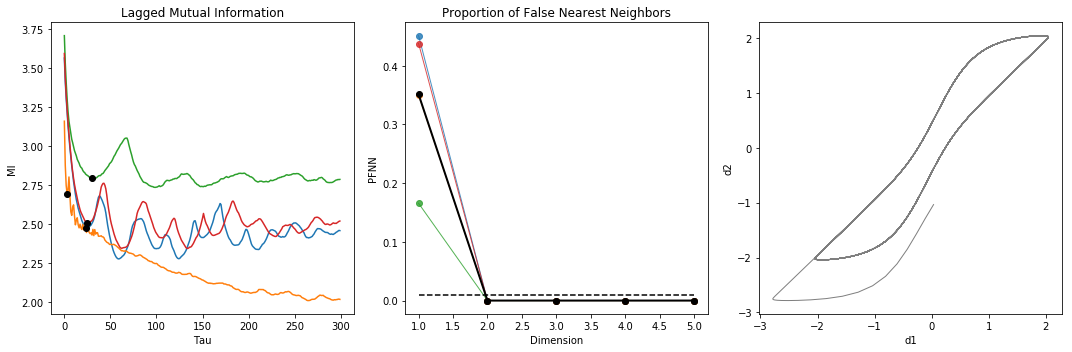

In [285]:
plot_chan, plot_step = 2, 5
data_de = de.delay_embed(data[plot_chan,:], int(opt_delay[plot_chan,0]), recon_dim[plot_chan]).T
plt.figure(figsize=(15,5))
plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=False)

### Delay embedding correctly retrieves attractor dimension
The up-projected van der Pol attractor is 2D in reality, and DE correctly identifies the embedding dimension, which is a relief.

In [286]:
ntrials = 20
data = np.matmul(np.random.randn(ntrials,2), np.array([x_o,y_o]))
nbins, max_tau = 50,300
max_dim, pfnn_thr, R_thr, A_thr = 5, 0.01, 15., 2.
MI, opt_delay, recon_dim, pfnn = compute_delayembedding(data, nbins, max_tau, max_dim, pfnn_thr, R_thr, A_thr)

(9, 2.805213057045195) 2
(29, 2.7876568927609973) 2
(26, 2.643255913215098) 2
(4, 2.0238599418723933) 2
(31, 2.7648657841783906) 2
(32, 2.779482333097116) 2
(2, 2.3633063061635706) 2
(24, 2.4408177593262583) 2
(26, 2.774893442799892) 2
(23, 2.4613996120209714) 2
(24, 2.4538119516451653) 2
(5, 2.8197510728085633) 2
(29, 2.7905815564112615) 2
(26, 2.6365055102156534) 2
(25, 2.4564079307465603) 2
(23, 2.798690971439026) 2
(25, 2.526735631722179) 2
(2, 2.339074142946945) 2
(7, 2.8416537940263593) 2
(2, 2.462557252457393) 2


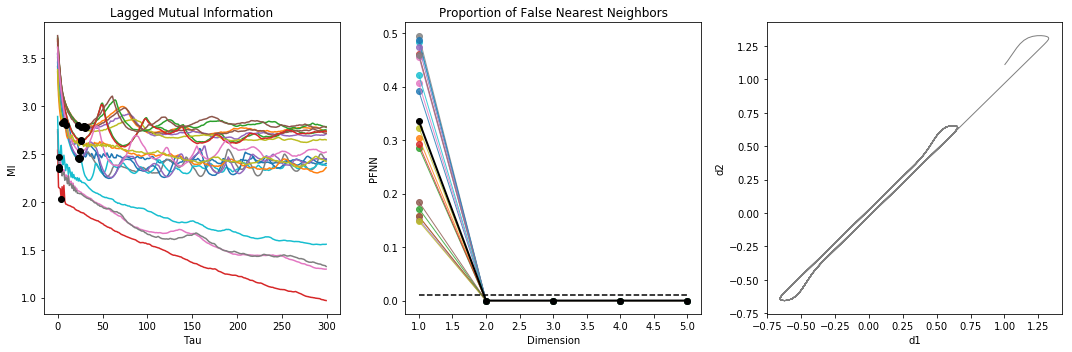

In [290]:
plot_chan, plot_step = 10, 5
data_de = de.delay_embed(data[plot_chan,:], int(opt_delay[plot_chan,0]), recon_dim[plot_chan]).T
plt.figure(figsize=(15,5))
plot_de_stats(data_de, plot_chan, plot_step, MI, opt_delay, recon_dim, pfnn, max_dim, pfnn_thr, log_pfnn=False)

In [3]:
def compute_features(data, fs, fit_range=[10,100]):
    f_axis,psd = spectral.psd(x,fs, flim=200)
    plt.subplot(1,2,1)
    plt.loglog(f_axis,psd)
    
    feat = np.zeros(5)
    # linear fit
    feat[0] = -spectral.fit_slope(f_axis,psd,fit_range)[0]
    
    # fooof full linear fit
    fn = FOOOF(verbose=False)
    fn.fit(f_axis, psd, fit_range)
    feat[1] = fn.get_results().background_params[-1]
    
    # fooof full knee fit
    fn = FOOOF(background_mode='knee',verbose=False)
    fn.fit(f_axis, psd, fit_range)
    feat[2] = fn.get_results().background_params[1]
    feat[3] = fn.get_results().background_params[2]
    
    #dfa
    t_scales, df, alpha = dfa.dfa(x,fs,n_scales=20, min_scale=0.05, max_scale=5, deg=1, method='dfa')
    feat[4] = alpha
    
    print('PSD slope: %f'%feat[0])
    print('FOOOFed PSD slope: %f'%feat[1])
    print('kneeFOOOFed PSD slope: %f'%feat[3])
    print('DFA exponent & DFA estimated 1/f: %f, %f' %(alpha, 2*alpha-1))

    plt.subplot(1,2,2)
    plt.loglog(t_scales, df, '.', label='DFA');
    plt.legend()
    return feat

# DFA tests
### Generate pure power-law colored noise and compute Hurst exponent & slope.

True slope: 1.500000
PSD slope: 1.506914
FOOOFed PSD slope: 1.508403
kneeFOOOFed PSD slope: 1.486080
DFA exponent & DFA estimated 1/f: 1.247537, 1.495073


array([ 1.50691422,  1.50840288, -1.90905796,  1.48608012,  1.24753653])

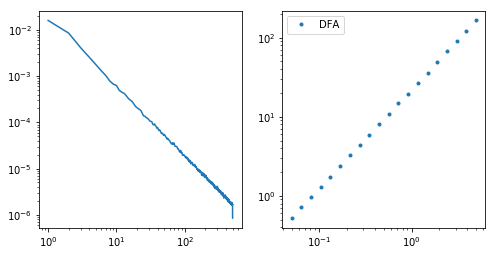

In [106]:
exp = -1.5
fs = 1000
T = 600
# generate colored noise with expected power law exponent
x = utils.sim_powerlaw_signal(T,fs,exponent=exp)
f_axis,psd = spectral.psd(x,1000)
print('True slope: %f'%-exp)
plt.figure(figsize=(8,4))
compute_features(x,fs)

# Generate time series from Lorenz attractor

PSD slope: 6.778842
FOOOFed PSD slope: 6.778842
kneeFOOOFed PSD slope: 6.868342
DFA exponent & DFA estimated 1/f: 1.461999, 1.923999


array([6.77884194, 6.77884194, 6.60693547, 6.86834249, 1.46199941])

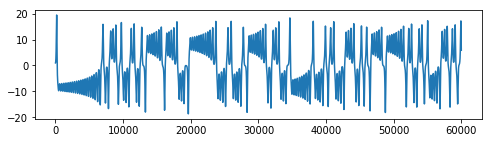

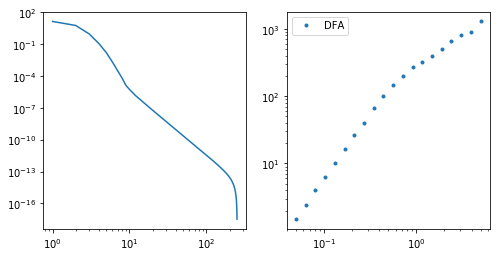

In [107]:
# Lorenz paramters and initial conditions
T,fs = 120,500
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 1, 1, 1.05
x,y,z = sim_lorenz(T,fs,init=(u0, v0, w0), args=(sigma, beta, rho))
sig = x
plt.figure(figsize=(8,2))
plt.plot(sig)
plt.figure(figsize=(8,4))
compute_features(sig,fs,[1,100])

# Lorentzian colored noise

PSD slope: 0.387492
FOOOFed PSD slope: 0.360718
kneeFOOOFed PSD slope: 2.115367
DFA exponent & DFA estimated 1/f: 0.536964, 0.073927


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PSD slope: 0.795787
FOOOFed PSD slope: 0.694626
kneeFOOOFed PSD slope: 2.165680
DFA exponent & DFA estimated 1/f: 0.588654, 0.177308


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PSD slope: 1.246591
FOOOFed PSD slope: 1.074345
kneeFOOOFed PSD slope: 1.874828
DFA exponent & DFA estimated 1/f: 0.636739, 0.273477


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PSD slope: 1.579535
FOOOFed PSD slope: 1.417260
kneeFOOOFed PSD slope: 1.896806
DFA exponent & DFA estimated 1/f: 0.703878, 0.407755


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PSD slope: 1.876889
FOOOFed PSD slope: 1.779973
kneeFOOOFed PSD slope: 1.936633
DFA exponent & DFA estimated 1/f: 0.904551, 0.809102


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PSD slope: 2.015231
FOOOFed PSD slope: 1.993612
kneeFOOOFed PSD slope: 2.036748
DFA exponent & DFA estimated 1/f: 1.021337, 1.042673


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'PSD (vary decay time)')

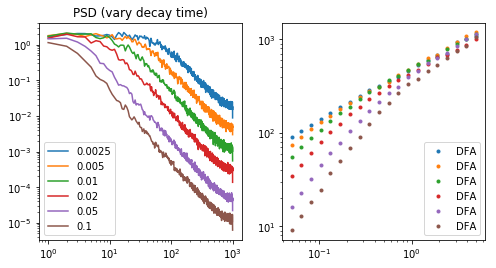

In [118]:
T = 60
fs = 2000
taus = [0.0025, 0.005, 0.01, 0.02, 0.05, 0.1]
feat = np.zeros((5,len(taus)))
fit_freqs = [2,100]
plt.figure(figsize=(8,4))
for i, tau in enumerate(taus):
    x = ndsp.sim_synaptic_noise(T,fs,tauD=tau)
    feat[:,i] = compute_features(x,fs,fit_freqs)

plt.subplot(1,2,1)
plt.legend(taus)
plt.title('PSD (vary decay time)')
    

Text(0,0.5,'Knee Fit Knee')

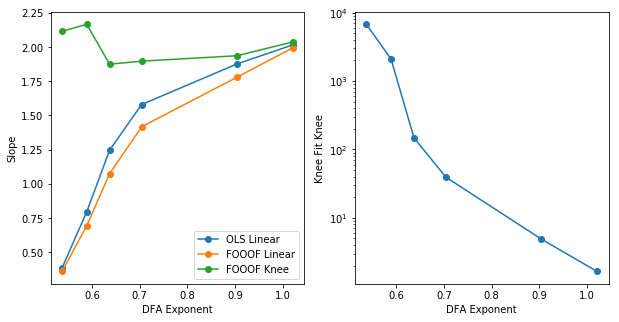

In [119]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in [0,1,3]:
    plt.plot(feat[-1,:], feat[i,:], '-o')
plt.legend(('OLS Linear', 'FOOOF Linear', 'FOOOF Knee'))
plt.xlabel('DFA Exponent')
plt.ylabel('Slope')
plt.subplot(1,2,2)
plt.plot(feat[-1,:], feat[2,:], '-o')
plt.yscale('log')
plt.xlabel('DFA Exponent')
plt.ylabel('Knee Fit Knee')

### Testing my code runtime speed

(157, 0.8851322990337012)


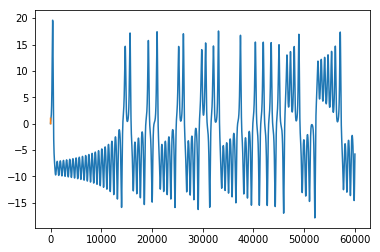

In [65]:
# Lorenz paramters and initial conditions
T,fs = 60,1000
sigma, beta, rho = 10, 2.667, 28
u0, v0, w0 = 0, 1, 1.05
x,y,z = sim_lorenz(T,fs,init=(u0, v0, w0), args=(sigma, beta, rho))
plt.plot(x)

tMI, dMI = de.compute_delay_MI(x,50,1000)
opt_delay = de.find_valley(dMI)
print(opt_delay)
#plt.plot(dMI)

# del_R, rel_R = de.compute_nn_dist(x,opt_delay[0],5)
# recon_dim, pfnn = de.compute_attractor_dim(del_R,rel_R)
recon_dim, pfnn = de.pfnn_de_dim(x,opt_delay[0])
plt.plot(pfnn)
#print(recon_dim, pfnn)